In [29]:
# google drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import seaborn as sns

from drive.MyDrive.Kaggle.June_2022_na_imputation.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Kaggle/June_2022_na_imputation/src/data.csv', index_col='row_id')
sample = pd.read_csv('/content/drive/MyDrive/Kaggle/June_2022_na_imputation/src/sample_submission.csv', index_col='row-col')

In [4]:
col_list, F1, F2, F3, F4, na_cols = get_lists(data)

In [5]:
def show_perc_values_missing(df):
    ncounts = pd.DataFrame([df.isna().mean()]).T
    ncounts = ncounts.rename(columns={0: "train_missing"})

    ncounts.query("train_missing > 0").plot(
        kind="barh", figsize=(8, 15), title="% of Values Missing"
    )
    plt.show()

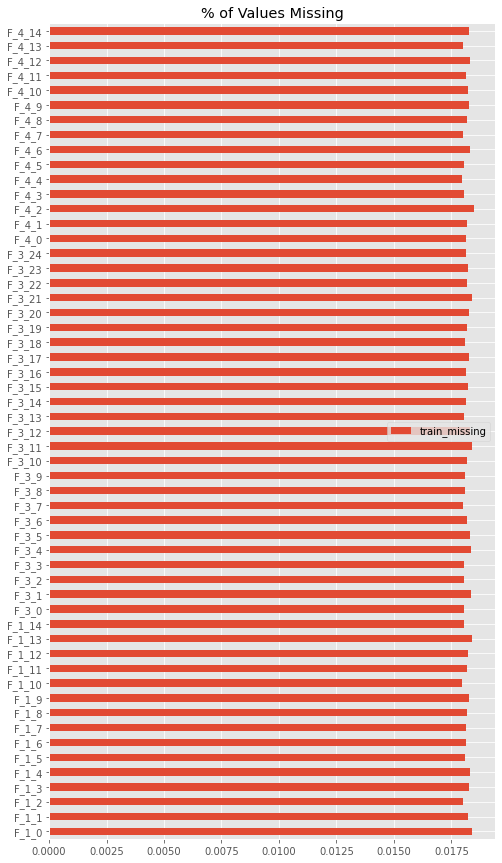

In [6]:
show_perc_values_missing(data)

## about 1.8% missing from each numerical column. For proper validation we will duplicate this in the no na data so we can train using na cnt as a feature!

In [11]:
data['n_missing'] = data.isna().sum(axis=1)

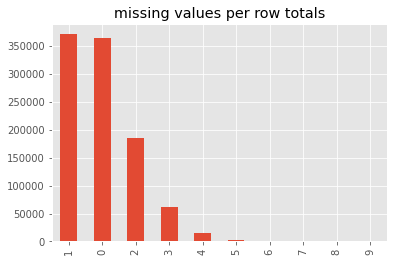

In [12]:
data['n_missing'].value_counts().plot(kind='bar', title='missing values per row totals')

In [15]:
data_with_no_na = data[data['n_missing'] == 0]
data_with_no_na

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14,n_missing
row_id,,,,,,,,,,,,,,,,,,,,,
6,0.533210,1.662285,0.601138,-0.662212,0.033856,-0.056208,-1.781594,0.326768,1.583396,-0.345895,...,4.226621,-1.136903,0.171289,0.703419,-0.779643,4.721938,1.835678,-6.408681,0.538917,0
8,-0.334935,-0.801940,-0.754364,-0.369206,0.781484,1.024585,-0.394121,-0.588350,0.092130,0.106974,...,2.535868,-0.617469,0.107925,-1.063796,-0.128948,3.340392,-0.966351,0.899595,-0.037505,0
9,0.144170,-0.580150,-0.896780,-0.550178,1.231237,-0.474318,-1.230894,0.474766,0.367473,-0.256849,...,1.543487,0.823975,0.036584,-1.029416,0.637053,0.681586,1.674981,-1.291278,0.553247,0
15,0.386307,-0.164298,-1.208667,0.768579,-2.200503,-1.498463,0.120240,0.865945,1.371115,1.627371,...,-0.854097,-1.151623,0.480169,-0.112417,0.154438,3.835651,-4.028104,-2.736279,0.190985,0
16,0.641497,0.714770,0.958424,0.765871,-1.713403,-1.081687,0.943967,0.329246,2.207749,-1.027082,...,0.674887,1.679765,0.130678,0.421721,0.585881,-0.348452,-0.782981,3.389371,-0.487223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999989,0.170037,-0.211452,-2.404505,-0.507762,0.407780,0.747040,1.238974,0.507713,-1.320281,-0.398096,...,-0.949488,-4.463064,-0.235551,-0.334151,-1.630128,-9.629801,4.005267,-3.800358,-1.961221,0
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733,0
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807,0


## So, about 36% of the data has no nas that we can use to insert nas.
- No nas are found in F2
- In another codebook someone found that the nas are distrubted randomly
- Ensure only ~1.8% of data has nas

In [16]:
ground_truth = data_with_no_na.drop(columns='n_missing').copy()

In [51]:
data_with_no_na.drop(columns='n_missing', inplace=True)

In [20]:
for col in na_cols:
    new_na_rows = data_with_no_na[col].sample(frac=0.018).index
    data_with_no_na.loc[new_na_rows, col] = np.NaN

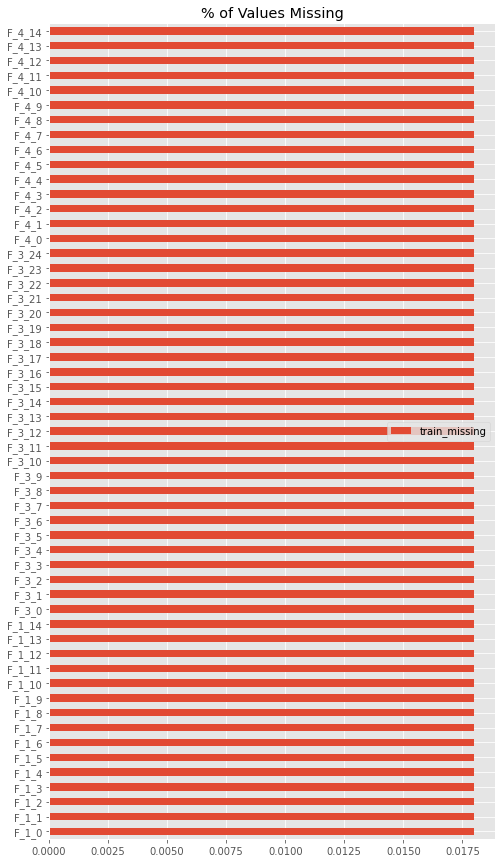

In [21]:
show_perc_values_missing(data_with_no_na)

## now we have a dataset with exactly 1.8% missing ew can use to train and test models with

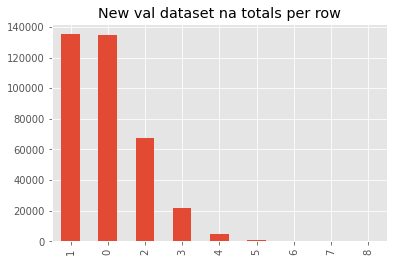

In [25]:
data_with_no_na['n_missing'] = data_with_no_na.isna().sum(axis=1)
data_with_no_na['n_missing'].value_counts().plot(kind='bar', title='New val dataset na totals per row')

## Its not quite the same distribution but that is most likely due to the smaller dataset we are working with

In [26]:
def RMSE(y_pred, y_true):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [31]:
si = SimpleImputer(strategy='mean', add_indicator=False)

In [53]:
folds = KFold(n_splits=5)

rmse_train = []
rmse_val = []

for i, (train_idx, val_idx) in enumerate(folds.split(data_with_no_na)):
    print("CV fold: "+str(i+1))

    train_imputed = si.fit_transform(data_with_no_na.iloc[train_idx])
    train_imputed = pd.DataFrame(train_imputed, columns=data_with_no_na.columns)

    val_imputed = si.transform(data_with_no_na.iloc[val_idx])
    val_imputed = pd.DataFrame(val_imputed, columns=data_with_no_na.columns)

    y_train = ground_truth.iloc[train_idx]
    y_val = ground_truth.iloc[val_idx]

    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_imputed)))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, val_imputed)))

    print("training error: " + str(rmse_train[-1]))
    print("val error: " + str(rmse_val[-1]))

CV fold: 1
training error: 0.15847771640916478
val error: 0.15710944448719558
CV fold: 2
training error: 0.15780235245068983
val error: 0.15980614166217652
CV fold: 3
training error: 0.15789969108802018
val error: 0.15942016296681064
CV fold: 4
training error: 0.1586990744162097
val error: 0.15621338919144384
CV fold: 5
training error: 0.15814459861478758
val error: 0.15844576781879596


## Not bad, not to train a NN on it, I beleive that model will benefit the most from being training on an na count

In [55]:
data_with_no_na.to_csv('/content/drive/MyDrive/Kaggle/June_2022_na_imputation/src/data_fake_nas.csv', index='row_id')